In [1]:
import sys
sys.path.append('../src')

import network as nw
import torch
import generate_kvadraturen as gk
import bus
import road as rd
import traffic_lights as tl
import junction as jn
import numpy as np
import loading_json as load

In [2]:
T = 40
road_1 = rd.Road(2, 50, 5, torch.tensor([50.0], requires_grad=True), [],
               initial=lambda x : torch.ones_like(x) * 0.2,
               left_pos=(-1, 2), right_pos=(7,2),
               periodic=True, id = "road_1_fw")

road_2 = rd.Road(2, 50, 5, torch.tensor([50.0], requires_grad=True), [],
               initial=lambda x : torch.ones_like(x) * 0.2,
               left_pos=(-1, 4), right_pos=(7,4),
               periodic=True, id = "road_2_fw", max_dens=4)

road_3 = rd.Road(2, 50, 5, torch.tensor([50.0], requires_grad=True), [],
               initial=lambda x : torch.ones_like(x) * 0.2,
               left_pos=(-1, 6.2), right_pos=(7,6.2),
               periodic=True, id = "road_3_fw")

road_4 = rd.Road(2, 50, 5, torch.tensor([50.0], requires_grad=True), [],
               initial=lambda x : torch.ones_like(x) * 0.2,
               left_pos=(7,6.2), right_pos=(-1, 6.2),
               periodic=True, id = "road_3_bw")

road_5 = rd.Road(2, 50, 5, torch.tensor([50.0], requires_grad=True), [],
               initial=lambda x : torch.ones_like(x) * 0.2,
               left_pos=(-1, 8.2), right_pos=(7,8.2),
               periodic=True, id = "road_4_fw")

road_6 = rd.Road(2, 50, 5, torch.tensor([50.0], requires_grad=True), [],
               initial=lambda x : torch.ones_like(x) * 0.6,
               left_pos=(7,8.2), right_pos=(-1, 8.2),
               periodic=True, id = "road_4_bw")


roads = [road_1, road_2, road_3, road_4, road_5, road_6]
network = nw.RoadNetwork(roads, [], T)

In [3]:
ids = ["road_1_fw"]
stops = [("road_1_fw", 40)]
times = [60]
bus_1 = bus.Bus(ids, stops, times, network)

ids = ["road_2_fw"]
stops = [("road_2_fw", 40)]
times = [60]
bus_2 = bus.Bus(ids, stops, times, network)

ids = ["road_3_fw"]
stops = [("road_3_fw", 40)]
times = [60]
bus_3 = bus.Bus(ids, stops, times, network)

ids = ["road_4_fw"]
stops = [("road_4_fw", 40)]
times = [60]
bus_4 = bus.Bus(ids, stops, times, network)

bus_network = nw.RoadNetwork(roads, [], T, busses=[bus_1, bus_2, bus_3, bus_4])

In [4]:
densities, queues, bus_lengths, bus_delays = bus_network.solve_cons_law()

Bus  reached bus stop 0 at time 5.907153606414795, should wait for 54.06129837036133 seconds
Bus  reached bus stop 0 at time 5.907153606414795, should wait for 54.009681701660156 seconds
Bus  reached bus stop 0 at time 5.907153606414795, should wait for 54.03165054321289 seconds
Bus  reached bus stop 0 at time 5.907153606414795, should wait for 54.044944763183594 seconds


In [5]:
# Checking the slowdown factors:
dt = 0.5
t = torch.tensor(50.0)
slowdown_factors = [torch.ones(road.N_internal+1) for road in bus_network.roads]
slowdown_indexes = []
for bus in bus_network.busses:
    slowdown_factors, slowing_idx = bus_network.update_position_of_bus(bus, dt, t, slowdown_factors)
    if slowing_idx is not None:
        slowdown_indexes.append(slowing_idx)

In [6]:
for idx in slowdown_indexes:
    print(slowdown_factors[idx])
    # print(idx)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.2213, 0.6054, 0.9947, 1.0000, 1.0000,
        1.0000, 1.0000], grad_fn=<MinimumBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.8837, 0.9405, 0.9992, 1.0000, 1.0000,
        1.0000, 1.0000], grad_fn=<SubBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.5328, 0.7632, 0.9968, 1.0000, 1.0000,
        1.0000, 1.0000], grad_fn=<SubBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.3770, 0.6843, 0.9958, 1.0000, 1.0000,
        1.0000, 1.0000], grad_fn=<SubBackward0>)


In [8]:
# dt = 0.31
# t = 40
# slowdown_factors = [torch.ones(road.N_internal + 1) for road in bus_network.roads]
# for bus in bus_network.busses:
#     road_id, length, next_id = bus.get_road_id()
#     i, road = bus_network.get_road(road_id)
#     # This should be equal for all and in fact it is
#     slowdown_factors[i], bus_started = bus.get_slowdown_factor(slowdown_factors[i].clone(), road_id,
#                                                                length, road)
#     slowing_idx = i
#     if road.max_dens == 1:
#         opposite_road = None
#         if i > 0: 
#             if bus_network.roads[i-1].id[:-2] == road.id[:-2]:
#                 opposite_road = bus_network.roads[i-1]
#         if i < len(bus_network.roads)-1:
#             if bus_network.roads[i+1].id[:-2] == road.id[:-2]:
#                 opposite_road = bus_network.roads[i+1]
#         if opposite_road is not None:
#             # print(road_id, opposite_road.id) # Looks good
#             # print(opposite_road.rho) # Also looks good
#             internal = torch.flip(opposite_road.rho[opposite_road.pad-1:-opposite_road.pad+1],dims=[0])
#             avg = (internal[1:] + internal[:-1]) / 2
#             # avg = torch.ones_like(avg)
#             print(avg) # Looks good
#             print(slowdown_factors[i])
#             print(torch.ones(road.N_internal+1) - (1. - slowdown_factors[i]) * (1. + avg) / 2)

In [9]:
densities = load.convert_from_tensor(densities)
queues = load.convert_from_tensor(queues)
bus_lengths = load.convert_from_tensor(bus_lengths)

In [10]:
import opengl_generate_gif as opengl

In [11]:
# Create gif:
opengl.draw_busses_w_densities(bus_network, [bus_1, bus_2, bus_3, bus_4], bus_lengths, densities, "bus_slowdown_example.gif", "../background_imgs/white_background.png")

End of simulation reached!
Saving GIF as: bus_slowdown_example.gif


: 

In [ ]:
def calculate_slowdown_factor(d, alpha = 0.5, beta = 2):
    return torch.max(torch.tensor(0.0), torch.sigmoid(alpha * d + 5) - torch.sigmoid(beta * d - 5))

In [ ]:
distances = torch.linspace(-20, 20, 100)
factors = calculate_slowdown_factor(distances)

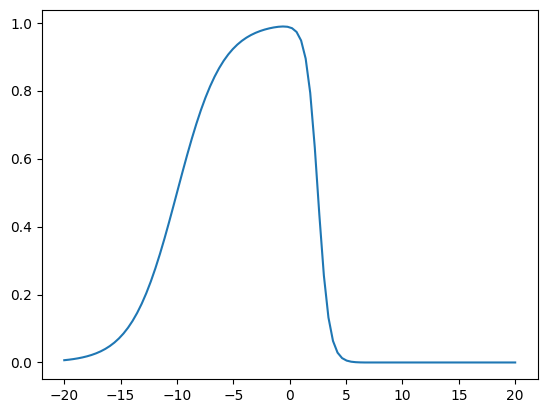

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.array(distances), np.array(factors))
plt.show()